# CineFeel_Phase_4.Create_Feeling_Graph

# 환경 설정 및 데이터 준비

In [ ]:
# prompt: 현재 런타임의 사양과, GPU 확인

!nvidia-smi

Thu Aug  7 01:18:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.20             Driver Version: 570.133.20     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   45C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 라이브러리 설치

In [ ]:
!pip install fer opencv-python-headless matplotlib moviepy --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.6 MB/s eta 0:00:00


## 영상준비

In [ ]:
# prompt: sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/video/0003_youtube_trailer_01.mp4 버킷에서 해당 영상 다운로드

video_source = "sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/video/0003_youtube_trailer_01.mp4"

!gsutil cp gs://{video_source} .

Copying gs://sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/video/0003_youtube_trailer_01.mp4...
/ [1 files][  4.4 MiB/  4.4 MiB]                                                
Operation completed over 1 objects/4.4 MiB.                                      


In [ ]:
video_path = "/content/0003_youtube_trailer_01.mp4"

In [ ]:
import cv2
import os

frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_rate = 5
frame_interval = int(fps // frame_rate)

frames = []
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count % frame_interval == 0:
        frame_path = f"{frame_dir}/frame_{frame_count}.jpg"
        cv2.imwrite(frame_path, frame)
        frames.append(frame_path)
    frame_count += 1

cap.release()


### 모든 프레임 추출

In [ ]:
import cv2
import os

# 이전에 생성된 프레임이 있다면 삭제합니다.
frame_dir = "frames"
if os.path.exists(frame_dir):
    for f in os.listdir(frame_dir):
        os.remove(os.path.join(frame_dir, f))
else:
    os.makedirs(frame_dir, exist_ok=True)


cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) # 최종 영상 합성에 필요하므로 fps는 저장해 둡니다.

frames = []
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # 모든 프레임을 저장합니다.
    frame_path = f"{frame_dir}/frame_{frame_count}.jpg"
    cv2.imwrite(frame_path, frame)
    frames.append(frame_path)
    frame_count += 1

cap.release()

print(f"총 {frame_count}개의 프레임을 추출하여 'frames' 디렉토리에 저장했습니다.")
print(f"영상 FPS: {fps}")

총 5167개의 프레임을 추출하여 'frames' 디렉토리에 저장했습니다.
영상 FPS: 30.0


In [ ]:
# prompt: frames를 zip으로 압축하여, sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/photo 버킷에 업로드. 파일명은 squid_game_example

import zipfile
import os

# Zip 파일 이름 설정
zip_filename = "squid_game_example.zip"

# Zip 파일 생성 및 프레임 추가
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for frame_path in frames:
        zipf.write(frame_path)

# Google Cloud Storage 버킷에 업로드
bucket_name = "sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/photo"  # 버킷 이름을 적절히 수정
!gsutil cp {zip_filename} gs://{bucket_name}/

print(f"{zip_filename} 파일을 gs://{bucket_name}/에 업로드했습니다.")

# frames 디렉토리 및 zip 파일 삭제 (선택 사항)
!rm -rf frames
!rm squid_game_example.zip

Copying file://squid_game_example.zip [Content-Type=application/zip]...
\
Operation completed over 1 objects/131.7 MiB.                                    
squid_game_example.zip 파일을 gs://sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/photo/에 업로드했습니다.


# 얼굴 탐지 및 감정 분석

각 프레임에서 여러 인물의 얼굴을 탐지하고, 얼굴 위치에 경계 상자(bounding box)를 그리고, 각 인물의 감정 데이터를 저장하도록 분석 코드를 수정합니다.

In [ ]:
import sys
!{sys.executable} -m pip install tqdm --quiet

from fer import FER
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

# mtcnn=True 옵션을 사용하면 더 정확한 얼굴 탐지가 가능하지만, 처리 속도가 느릴 수 있습니다.
detector = FER(mtcnn=True)
emotion_results_per_frame = []

print(f"총 {len(frames)}개의 프레임에 대한 감정 분석을 시작합니다. 이 작업은 다소 시간이 걸릴 수 있습니다.")

# tqdm을 사용하여 진행 상황을 표시합니다.
for frame_path in tqdm(frames, desc="감정 분석 중"):
    try:
        img = Image.open(frame_path).convert("RGB")
        img_np = np.array(img)

        # detect_emotions는 프레임 안의 모든 얼굴을 찾아 리스트로 반환합니다.
        result = detector.detect_emotions(img_np)
        emotion_results_per_frame.append(result)
    except Exception as e:
        # 특정 프레임에서 오류가 발생하더라도 전체 프로세스가 중단되지 않도록 합니다.
        # print(f"프레임 처리 오류 {frame_path}: {e}") # 오류가 발생한 프레임을 확인하고 싶을 경우 주석 해제
        emotion_results_per_frame.append([]) # 오류 발생 시 빈 리스트 추가

print("\n감정 분석이 완료되었습니다.")
face_detected_frames = sum(1 for r in emotion_results_per_frame if r)
print(f"얼굴이 탐지된 프레임 수: {face_detected_frames} / {len(frames)}")

총 5167개의 프레임에 대한 감정 분석을 시작합니다. 이 작업은 다소 시간이 걸릴 수 있습니다.


감정 분석 중:   0%|          | 0/5167 [00:00<?, ?it/s]


감정 분석이 완료되었습니다.
얼굴이 탐지된 프레임 수: 4567 / 5167


# 분석 결과 시각화

감정 분석이 잘 되었는지 확인하기 위해, 몇 개의 샘플 프레임에 탐지된 얼굴 영역과 가장 확률이 높은 감정을 표시하여 확인합니다.

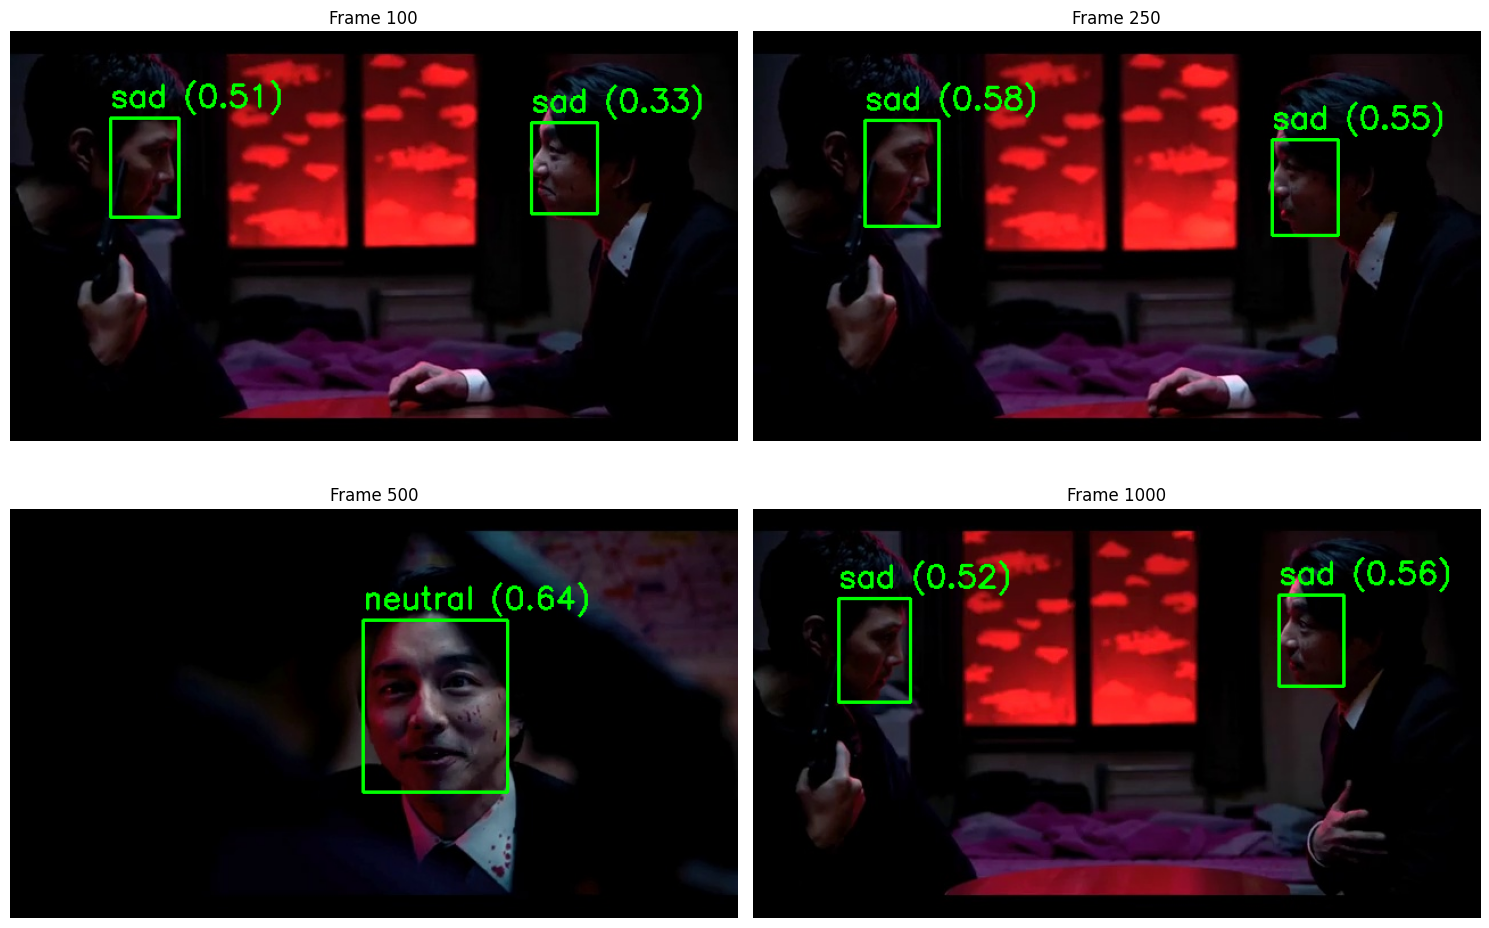

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 확인할 샘플 프레임 인덱스
sample_indices = [100, 250, 500, 1000]

plt.figure(figsize=(15, 10))

for i, frame_idx in enumerate(sample_indices):
    frame_path = frames[frame_idx]
    results_in_frame = emotion_results_per_frame[frame_idx]

    # 원본 이미지 로드
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 탐지된 각 얼굴에 대해 박스와 감정 텍스트 그리기
    if results_in_frame:
        for face_result in results_in_frame:
            box = face_result['box']
            # top_emotion() 메소드는 제공되지 않으므로, emotions 딕셔너리에서 가장 높은 값을 가진 감정을 찾습니다.
            emotions = face_result['emotions']
            top_emotion = max(emotions, key=emotions.get)
            top_score = emotions[top_emotion]

            x, y, w, h = box
            # 얼굴 주위에 사각형 그리기
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            # 감정 텍스트 표시
            text = f"{top_emotion} ({top_score:.2f})"
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Matplotlib을 사용하여 이미지 표시
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"Frame {frame_idx}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 감정 데이터 처리 및 시각화용 데이터 준비

**Reasoning**: 분석된 원본 데이터(`emotion_results_per_frame`)는 프레임마다 여러 얼굴 정보가 포함된 복잡한 구조입니다. 시각화를 위해 이 데이터를 가공하여 각 프레임을 대표하는 단일 감정을 추출합니다. 여기서는 프레임 내 모든 얼굴의 감정 점수를 합산하여 가장 총점이 높은 감정을 해당 프레임의 대표 감정으로 삼는 방식을 사용합니다.

In [ ]:
import pandas as pd

print("감정 분석 결과를 시각화용 데이터로 가공합니다.")

processed_emotions = []
# 각 프레임별로 처리
for frame_results in emotion_results_per_frame:
    if not frame_results:
        # 얼굴이 탐지되지 않은 경우 'neutral'로 처리
        processed_emotions.append({'emotion': 'neutral', 'score': 0.5})
        continue

    # 프레임 내 모든 얼굴의 감정 점수를 합산
    frame_emotion_scores = {}
    for face in frame_results:
        for emotion, score in face['emotions'].items():
            if emotion not in frame_emotion_scores:
                frame_emotion_scores[emotion] = 0
            frame_emotion_scores[emotion] += score

    # 가장 점수가 높은 감정을 해당 프레임의 대표 감정으로 선택
    if not frame_emotion_scores:
         top_emotion = 'neutral'
         top_score = 0.5
    else:
        top_emotion = max(frame_emotion_scores, key=frame_emotion_scores.get)
        # 점수는 정규화하여 0~1 사이 값으로 표현 (가장 높은 점수 / 전체 점수 합)
        total_score = sum(frame_emotion_scores.values())
        top_score = frame_emotion_scores[top_emotion] / total_score if total_score > 0 else 0

    processed_emotions.append({'emotion': top_emotion, 'score': top_score})

# 데이터프레임으로 변환하여 확인
emotion_df = pd.DataFrame(processed_emotions)
print("데이터 가공 완료. 상위 5개 결과:")
print(emotion_df.head())
print("\n프레임별 대표 감정 분포:")
print(emotion_df['emotion'].value_counts())

감정 분석 결과를 시각화용 데이터로 가공합니다.
데이터 가공 완료. 상위 5개 결과:
   emotion     score
0  neutral  0.500000
1    angry  0.410000
2    angry  0.464646
3    angry  0.420000
4    angry  0.415842

프레임별 대표 감정 분포:
emotion
sad         2929
neutral     1710
happy        264
angry        231
fear          19
surprise      14
Name: count, dtype: int64


## 감정 타임라인 그래프 생성

**Reasoning**: 가공된 데이터를 사용하여 영상 전체의 감정 변화를 한눈에 볼 수 있는 타임라인 그래프를 생성합니다. 이 그래프는 최종 영상의 하단에 추가되어 시각적인 분석을 돕습니다. Matplotlib을 사용하여 그래프를 생성하고 이미지 파일로 저장합니다.

In [ ]:
import matplotlib.pyplot as plt
import cv2

def create_emotion_timeline_plot(emotions_df, width):
    # 감정 종류별로 타임라인 데이터 생성
    unique_emotions = sorted(emotions_df['emotion'].unique()) # 감정 순서를 일정하게 정렬
    time = range(len(emotions_df))

    plt.figure(figsize=(width / 100, 2.5)) # 그래프 크기 지정 (너비는 영상에 맞추고 높이는 고정)

    # 각 감정에 대한 데이터를 쌓아서 표현 (Stacked Area Chart)
    # 각 시간 t에서의 y값은 해당 감정의 누적합
    y_values = {emo: [1 if e == emo else 0 for e in emotions_df['emotion']] for emo in unique_emotions}

    plt.stackplot(time, y_values.values(), labels=y_values.keys(), alpha=0.8)

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') # 범례를 그래프 밖에 표시
    plt.axis('off') # 축 정보는 보이지 않게 처리
    plt.tight_layout(pad=0)
    plt.savefig("emotion_timeline.png", bbox_inches='tight', pad_inches=0.1, dpi=100) # 그래프를 이미지 파일로 저장
    plt.close()

# 영상 프레임의 너비를 가져와서 그래프 너비를 맞춤
sample_frame = cv2.imread(frames[0])
frame_height, frame_width, _ = sample_frame.shape

print(f"영상 너비({frame_width}px)에 맞춰 감정 타임라인 그래프를 생성합니다.")
create_emotion_timeline_plot(emotion_df, frame_width)
print("그래프 'emotion_timeline.png'가 생성되었습니다.")

영상 너비(640px)에 맞춰 감정 타임라인 그래프를 생성합니다.
그래프 'emotion_timeline.png'가 생성되었습니다.


#  최종 영상 제작

**Reasoning**: 이제 모든 준비가 끝났습니다. 이 단계에서는 원본 비디오의 각 프레임, 해당 프레임에서 탐지된 모든 얼굴의 경계 상자와 감정 레이블, 그리고 이전에 생성한 감정 타임라인 그래프를 하나로 합치는 작업을 수행합니다. `cv2.VideoWriter`를 사용하여 이 모든 요소가 포함된 최종 비디오 파일을 생성합니다.

In [ ]:
import cv2
import numpy as np
from tqdm.notebook import tqdm

print("최종 영상 합성을 시작합니다. 이 작업은 다소 시간이 걸릴 수 있습니다.")

# 그래프 이미지 로드
graph_img = cv2.imread("emotion_timeline.png", cv2.IMREAD_UNCHANGED)

# 그래프 이미지 크기를 영상 너비에 맞게 조정
graph_h, graph_w, _ = graph_img.shape
new_graph_w = frame_width
# 원본 비율을 유지하면서 너비 조정
new_graph_h = int(graph_h * (new_graph_w / graph_w))
graph_img_resized = cv2.resize(graph_img, (new_graph_w, new_graph_h))

# 최종 영상 설정을 위한 VideoWriter 객체 생성
output_video_path = "final_emotion_video.mp4"
# mp4 포맷을 위해 'mp4v' 코덱 사용
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# fps는 원본 영상의 fps를 사용
# 프레임 크기는 (원본 너비, 원본 높이 + 그래프 높이)
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height + new_graph_h))

# 각 프레임에 대해 작업 수행
for i, frame_path in enumerate(tqdm(frames, desc="영상 합성 중")):
    frame = cv2.imread(frame_path)
    frame_results = emotion_results_per_frame[i]

    # 해당 프레임에 탐지된 얼굴이 있으면 박스와 감정 텍스트를 그림
    if frame_results:
        for face in frame_results:
            x, y, w, h = face['box']
            emotions = face['emotions']
            top_emotion = max(emotions, key=emotions.get)
            score = emotions[top_emotion]

            # 박스 그리기
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            # 텍스트 그리기
            text = f"{top_emotion} ({score:.2f})"
            cv2.putText(frame, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # 프레임과 그래프 이미지를 합치기 위한 배경 생성
    combined_frame = np.full((frame_height + new_graph_h, frame_width, 3), (0, 0, 0), dtype=np.uint8)
    # 원본 프레임 붙여넣기
    combined_frame[0:frame_height, 0:frame_width] = frame
    # 그래프 붙여넣기 (알파 채널 고려)
    y_offset = frame_height
    alpha_s = graph_img_resized[:, :, 3] / 255.0
    alpha_l = 1.0 - alpha_s
    for c in range(0, 3):
        combined_frame[y_offset:y_offset+new_graph_h, 0:new_graph_w, c] = (alpha_s * graph_img_resized[:, :, c] + \
                                                               alpha_l * combined_frame[y_offset:y_offset+new_graph_h, 0:new_graph_w, c])

    out.write(combined_frame)

out.release()
print(f"\n최종 영상이 '{output_video_path}' 경로에 저장되었습니다.")

최종 영상 합성을 시작합니다. 이 작업은 다소 시간이 걸릴 수 있습니다.


영상 합성 중:   0%|          | 0/5167 [00:00<?, ?it/s]


최종 영상이 'final_emotion_video.mp4' 경로에 저장되었습니다.


# Phase4+. 모델 및 데이터셋 변경

### 모델 성능 개선을 위한 Task 계획

1.  **맞춤형 데이터셋 준비**: 모델을 학습시키기 위해 가장 중요한 단계입니다. '분노', '공포', '슬픔' 등 각 감정별로 라벨링된 얼굴 이미지를 준비합니다. 기존 공개 데이터셋(FER-2013, AffectNet 등)을 사용하거나, 현재 영상에서 직접 프레임을 추출하고 수동으로 라벨을 지정하여 데이터셋을 구축할 수 있습니다.

2.  **모델 아키텍처 구성**: 새로운 모델을 처음부터 만드는 대신, 이미지 분류에 뛰어난 성능을 보이는 기존 모델(예: VGG16, ResNet)을 기반으로 감정 분류에 맞게 구조를 일부 수정하는 '전이 학습(Transfer Learning)' 방법을 사용합니다. 이렇게 하면 더 적은 데이터로도 높은 성능을 낼 수 있습니다.

3.  **모델 학습 실행**: 준비된 데이터셋을 사용하여 모델을 학습시킵니다. 이 과정에서 모델은 각 감정과 얼굴 이미지의 특징 사이의 관계를 학습하게 됩니다. 학습 진행 상황과 손실값/정확도 변화를 시각화하여 확인합니다.

4.  **학습된 모델 평가**: 학습이 완료된 모델이 '분노'와 '공포' 같은 특정 감정을 얼마나 잘 예측하는지 평가합니다. 혼동 행렬(Confusion Matrix)과 같은 지표를 통해 어떤 감정을 혼동하는지 구체적으로 분석합니다.

5.  **새로운 모델로 교체 및 추론**: 성능이 개선된 새로운 모델을 기존 분석 파이프라인에 통합합니다. 기존 `FER` 라이브러리 대신 우리가 직접 학습시킨 모델을 사용하여 감정 분석을 다시 수행하고, 결과가 개선되었는지 확인합니다.

6.  **Finish task**: 최종적으로 개선된 모델을 통해 얻은 감정 분석 결과를 요약하고, 초기 모델의 한계가 어떻게 극복되었는지 정리합니다.

환경 설정: YOLOv8 모델을 사용하기 위한 ultralytics 라이브러리를 설치하고, Kaggle 데이터셋을 다운로드하기 위한 환경을 구성합니다.
데이터셋 다운로드: 제안해주신 AffectNet YOLO 데이터셋을 Kaggle에서 다운로드하고 압축을 해제합니다. 이를 위해 Kaggle API 키 설정이 필요합니다.
YOLO 학습 구성: YOLO 모델이 데이터셋을 학습할 수 있도록, 데이터의 경로와 감정 클래스(angry, happy, sad 등) 정보가 담긴 YAML 설정 파일을 생성합니다.
YOLO 모델 학습: 사전 학습된 YOLOv8 모델을 기반으로, 준비된 AffectNet 감정 데이터셋을 사용하여 전이 학습(fine-tuning)을 시작합니다. 학습이 진행되는 동안 성능을 모니터링합니다.
학습된 모델로 추론 실행: 학습된 모델 중 가장 성능이 좋은 모델을 사용하여 기존 영상의 모든 프레임에 대해 다시 감정 분석을 수행합니다.
시각화 로직 재구성 및 영상 생성: 새로운 YOLO 모델의 출력 형식에 맞게 감정 데이터 처리 및 시각화 코드를 수정합니다. 얼굴 경계 상자와 감정 레이블, 그리고 타임라인 그래프를 포함한 최종 영상을 다시 제작합니다.
Finish task: 초기 FER 라이브러리를 사용했을 때의 한계와, 직접 학습시킨 YOLO 모델을 통해 어떻게 성능이 개선되었는지 비교 분석하고 최종 결과를 요약합니다.

# 환경 설정

### Subtask:
YOLOv8 및 Kaggle 라이브러리를 설치하여 모델 학습 및 데이터 다운로드 환경을 구성합니다.

**Reasoning**: YOLOv8 모델을 사용하기 위한 `ultralytics` 라이브러리와 Kaggle 데이터셋을 다운로드하기 위한 `kaggle` 라이브러리를 설치하여 개발 환경을 준비합니다.

In [ ]:
!pip install ultralytics kaggle --quiet

print("필수 라이브러리(ultralytics, kaggle) 설치가 완료되었습니다.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
필수 라이브러리(ultralytics, kaggle) 설치가 완료되었습니다.


# 데이터셋 다운로드

### Subtask:
제안해주신 AffectNet YOLO 데이터셋을 Kaggle에서 다운로드하고 압축을 해제합니다. 이를 위해 Kaggle API 키 설정이 필요합니다.

**Reasoning**: Kaggle API를 사용하여 인증하고, 'affectnet-yolo-format' 데이터셋을 다운로드한 후, 작업 디렉토리에 압축을 해제하여 모델 학습에 사용할 수 있도록 준비합니다.

In [ ]:
!pip install google-cloud-secret-manager --quiet

import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.1/218.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
# prompt: 구글 시크릿 매니저에 접근해서, 'kaggle-api-key'  키값의 밸류를 가져와 kaggle.json으로 저장

import json
from google.cloud import secretmanager

# Google Cloud project ID 가져오기
project_id = 'sesac-ljj0210' # 'YOUR_PROJECT_ID'를 실제 프로젝트 ID로 변경
if not project_id:
    raise ValueError("프로젝트 ID를 설정해야 합니다.")

# Secret Manager에서 Kaggle API 키 가져오기
client = secretmanager.SecretManagerServiceClient()
name = f"projects/{project_id}/secrets/kaggle-api-key/versions/latest"
response = client.access_secret_version(name=name)
payload = response.payload.data.decode('UTF-8')

# JSON 데이터 파싱 및 저장
kaggle_api_key = json.loads(payload)
with open('kaggle.json', 'w') as f:
    json.dump(kaggle_api_key, f)

# Kaggle API 설정
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API 키 설정이 완료되었습니다.")

Kaggle API 키 설정이 완료되었습니다.


In [ ]:
import kagglehub
import os

# kagglehub.dataset_download는 자동으로 압축을 해제하고 데이터셋의 경로를 반환합니다.
path = kagglehub.dataset_download("fatihkgg/affectnet-yolo-format")
print("Path to dataset files:", path)

# 아래 unzip 명령어는 kagglehub이 이미 압축을 해제했으므로 불필요하며 오류를 유발합니다.
# !unzip -q {path}

print("\n데이터셋 다운로드 및 준비가 완료되었습니다.")
print("데이터셋 위치:", path)

100%|██████████| 258M/258M [00:01<00:00, 203MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2

데이터셋 다운로드 및 준비가 완료되었습니다.
데이터셋 위치: /root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2


In [ ]:
import shutil
import os

# kagglehub 다운로드 경로 (이전 셀의 'path' 변수)
source_path = str(path)

# 복사할 새로운 위치
target_path = "/content/affectnet_dataset"

# 만약 폴더가 이미 존재한다면, 깨끗한 복사를 위해 삭제합니다.
if os.path.exists(target_path):
    shutil.rmtree(target_path)

# 전체 데이터셋 디렉토리를 복사합니다.
shutil.copytree(source_path, target_path)

print(f"데이터셋을 '{source_path}'에서 '{target_path}'로 성공적으로 복사했습니다.")

데이터셋을 '/root/.cache/kagglehub/datasets/fatihkgg/affectnet-yolo-format/versions/2'에서 '/content/affectnet_dataset'로 성공적으로 복사했습니다.


In [ ]:
# prompt: /content/affectnet_dataset/YOLO_format/data.yaml  야뮬파일 확인

!cat /content/affectnet_dataset/YOLO_format/data.yaml

data: "/kaggle/input/affectnet-yolo-format/YOLO_format"

train: "/kaggle/input/affectnet-yolo-format/YOLO_format/train/images"
val: "/kaggle/input/affectnet-yolo-format/YOLO_format/valid/images"
test: "/kaggle/input/affectnet-yolo-format/YOLO_format/test/images"

nc: 8

names:
  [
    "Anger",
    "Contempt",
    "Disgust",
    "Fear",
    "Happy",
    "Neutral",
    "Sad",
    "Surprise",
  ]

# Network configuration (choose other variations if desired)
network: "yolov8n"


In [ ]:
import yaml

# 데이터셋의 루트 경로를 지정합니다.
dataset_path = "/content/affectnet_dataset/YOLO_format"

# YAML 파일 내용을 실제 디렉토리 구조에 맞게 수정합니다.
# train, val, test 키에는 이미지 파일이 포함된 디렉토리의 상대 경로를 지정합니다.
# 원본 데이터셋의 검증 폴더 이름이 'valid'이므로 이를 반영합니다.
# 클래스 이름과 순서도 원본 data.yaml과 일치시킵니다.
data_yaml = {
    'path': dataset_path,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 8,  # 클래스 개수
    'names': ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
}

# 수정된 YAML 파일 저장
with open('affectnet_data.yaml', 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False, sort_keys=False)

print(f"'affectnet_data.yaml' 파일이 올바른 경로로 수정되었습니다.")
print("--- 수정된 설정 파일 내용 ---")
!cat affectnet_data.yaml
print("--------------------------")

'affectnet_data.yaml' 파일이 올바른 경로로 수정되었습니다.
--- 수정된 설정 파일 내용 ---
path: /content/affectnet_dataset/YOLO_format
train: train/images
val: valid/images
test: test/images
nc: 8
names:
- Anger
- Contempt
- Disgust
- Fear
- Happy
- Neutral
- Sad
- Surprise
--------------------------


# Yolov8_affectnet데이터 학습

In [ ]:
# prompt: 다운로드 받은 데이터셋, 야뮬파일과 Yolo8 모델을 이용해 학습 진행

# 이전에 생성한 올바른 설정 파일 'affectnet_data.yaml'을 사용합니다.
!yolo train model=yolov8n.pt data=affectnet_data.yaml epochs=10 imgsz=640 batch=16

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22574MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=affectnet_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_wi

## 평가

In [ ]:
# prompt: /content/runs/detect/train/weights/best.pt  모델 평가

!yolo val model=/content/runs/detect/train/weights/best.pt data=affectnet_data.yaml

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22574MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 428.5±374.5 MB/s, size: 8.3 KB)
val: Scanning /content/affectnet_dataset/YOLO_format/valid/labels.cache... 5406 images, 0 backgrounds, 0 corrupt: 100% 5406/5406 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 338/338 [00:28<00:00, 12.04it/s]
                   all       5406       5406      0.677      0.747       0.78       0.78
                 Anger        712        712       0.64      0.781      0.779      0.779
              Contempt        618        618      0.716      0.712      0.801      0.801
               Disgust        672        672      0.624      0.726      0.753      0.752
                  Fear        622        622      0.694      0.723      0.795      0.795
                 Happy        791  

In [ ]:
# prompt: 모델을 sesac-ljj-20250715/pjt_cinefeel/model 버킷에 업로드. {모델}_{데이터셋}_{에폭}으로 저장

import os

# 모델 경로
model_path = "/content/runs/detect/train/weights/best.pt"

# 버킷 경로
bucket_path = "gs://sesac-ljj-20250715/pjt_cinefeel/model"

# 모델 이름, 데이터셋, 에폭 정보
model_name = "yolov8n"
dataset_name = "affectnet"
epochs = "10"  # epochs 값을 변수에서 가져오거나 직접 지정

# 저장할 파일 이름
file_name = f"{model_name}_{dataset_name}_{epochs}.pt"

# 업로드 명령어 실행
!gsutil cp {model_path} {os.path.join(bucket_path, file_name)}

print(f"모델이 '{os.path.join(bucket_path, file_name)}'에 업로드되었습니다.")

Copying file:///content/runs/detect/train/weights/best.pt [Content-Type=application/vnd.snesdev-page-table]...
/ [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      
모델이 'gs://sesac-ljj-20250715/pjt_cinefeel/model/yolov8n_affectnet_10.pt'에 업로드되었습니다.


In [ ]:
# prompt: sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/photo/squid_game_example.zip 을 가져와서 {파일명}_frames 폴더에 unzip. 분석대상데이터 준비

import zipfile
import os

# Google Cloud Storage에서 zip 파일 다운로드
zip_file_gcs_path = "gs://sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/photo/squid_game_example.zip"
zip_file_local_path = "squid_game_example.zip"  # 로컬 저장 경로

!gsutil cp {zip_file_gcs_path} {zip_file_local_path}

# zip 파일 이름에서 확장자를 제외한 파일명 추출
file_name = os.path.splitext(zip_file_local_path)[0]

# 압축 해제할 폴더 경로 생성
extract_dir = f"{file_name}_frames"

# 폴더 생성 (이미 존재하는 경우 덮어쓰지 않음)
os.makedirs(extract_dir, exist_ok=True)

# zip 파일 압축 해제
with zipfile.ZipFile(zip_file_local_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"'{zip_file_local_path}' 파일이 '{extract_dir}' 폴더에 압축 해제되었습니다.")



Copying gs://sesac-ljj-20250715/pjt_cinefeel/src/source_collector/result/photo/squid_game_example.zip...
\
Operation completed over 1 objects/131.7 MiB.                                    
'squid_game_example.zip' 파일이 'squid_game_example_frames' 폴더에 압축 해제되었습니다.
압축 해제된 프레임 파일 개수: 0


In [ ]:
# prompt: 얼굴 탐지 및 감정 분석 실시, 결과 파일 시각화 및 squid_game_example_result 로 압축하여 sesac-ljj-20250715/pjt_cinefeel 버킷에 저장

import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np
from tqdm.notebook import tqdm
import zipfile

# YOLO 모델 로드 (학습된 모델 경로로 변경)
model = YOLO('/content/runs/detect/train/weights/best.pt')

# 이미지가 있는 폴더 경로 (압축 해제된 폴더 경로로 변경)
image_folder = '/content/squid_game_example_frames/frames'

# 결과를 저장할 리스트
results = []

# 이미지 파일 목록 가져오기
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
image_files.sort()  # 파일 이름 순서대로 정렬

for image_file in tqdm(image_files, desc="이미지 처리 중"):
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)

    # 추론 실행
    predictions = model(img)

    # 결과 처리 및 저장
    for pred in predictions:
        boxes = pred.boxes.cpu().numpy()
        for box, conf, cls in zip(boxes.xyxy, boxes.conf, boxes.cls):
            x1, y1, x2, y2 = map(int, box)
            confidence = float(conf)
            class_id = int(cls)
            class_name = model.names[class_id]  # 클래스 이름 가져오기

            # 결과 저장 (파일 이름, 경계 상자, 감정, 신뢰도)
            results.append({
                "frame": image_file,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "emotion": class_name,
                "confidence": confidence
            })

            # 이미지에 경계 상자와 감정 표시
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{class_name} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # 결과 이미지 저장
    output_image_path = os.path.join("squid_game_example_result", image_file)  # 결과 폴더
    os.makedirs("squid_game_example_result", exist_ok=True)
    cv2.imwrite(output_image_path, img)

# 결과를 DataFrame으로 변환
df = pd.DataFrame(results)

# 결과 CSV 파일로 저장
df.to_csv("squid_game_example_result.csv", index=False)


# 결과 폴더 압축
output_zip_filename = "squid_game_example_result.zip"
with zipfile.ZipFile(output_zip_filename, 'w') as zipf:
    for foldername, _, filenames in os.walk("squid_game_example_result"):
        for filename in filenames:
            zipf.write(os.path.join(foldername, filename))

# Google Cloud Storage에 업로드
bucket_name = "sesac-ljj-20250715/pjt_cinefeel"
!gsutil cp {output_zip_filename} gs://{bucket_name}/

print(f"'{output_zip_filename}' 파일이 gs://{bucket_name}/에 업로드되었습니다.")

이미지 처리 중:   0%|          | 0/5167 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Speed: 1.3ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Fear, 9.4ms
Speed: 2.0ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Fear, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Fear, 7.7ms
Speed: 1.6ms preprocess, 7.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 7.9ms
Speed: 1.6ms preprocess, 7.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Fear, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Fear, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Fear, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 3

In [ ]:
# prompt: 분석된 csv를 바탕으로 동영상을 재구성해야해. csv파일을 바탕으로, https://console.cloud.google.com/vertex-ai/colab/notebooks?hl=ko&inv=1&invt=Ab4zBA&project=sesac-ljj0210&activeNb=projects%2Fsesac-ljj0210%2Flocations%2Fus-central1%2Frepositories%2Ff0639cb0-cba8-4366-8d03-7b0b368f76c0 이 셀과 같이 프레임별 시각화를 진행하자. 중간중간 얼굴이 인식되지 않는 프레임들은 원본영상의 프레임들이 그대로 들어가야 해. 그리고 감정과 신뢰도 값은 박스 내부에 위치시키자

import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import zipfile

# 결과 CSV 파일 경로
csv_file_path = "squid_game_example_result.csv"

# 결과 DataFrame 로드
df = pd.read_csv(csv_file_path)

# 원본 비디오 경로
video_path = "/content/0003_youtube_trailer_01.mp4"

# 원본 비디오 정보 가져오기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()


# 결과 비디오 설정
output_video_path = "final_emotion_video_yolo.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# 프레임별 처리
for frame_num in tqdm(range(total_frames), desc="비디오 생성 중"):
    # 원본 프레임 읽기
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        continue

    # 현재 프레임에 해당하는 감정 데이터 가져오기
    frame_data = df[df['frame'] == f'frame_{frame_num}.jpg']

    # 감정 데이터가 있는 경우
    if not frame_data.empty:
        for _, row in frame_data.iterrows():
            x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
            emotion = row['emotion']
            confidence = row['confidence']

            # 경계 상자 그리기
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # 감정과 신뢰도 텍스트 박스 안에 표시
            text = f"{emotion} {confidence:.2f}"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
            text_x = x1 + (x2 - x1 - text_size[0]) // 2
            text_y = y1 + (y2 - y1 + text_size[1]) // 2
            cv2.putText(frame, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


    # 처리된 프레임 저장
    out.write(frame)

out.release()

print(f"최종 영상이 '{output_video_path}'에 저장되었습니다.")

비디오 생성 중:   0%|          | 0/5167 [00:00<?, ?it/s]

최종 영상이 'final_emotion_video_yolo.mp4'에 저장되었습니다.


In [ ]:
# prompt: 영상과 csv파일, 그리고 그래프를 sesac-ljj-20250715/pjt_cinefeel 버킷에 업로드하자

import os

# 파일 및 폴더 경로 설정
video_path = "final_emotion_video_yolo.mp4"
csv_path = "squid_game_example_result.csv"
graph_path = "emotion_timeline.png"
zip_path = "squid_game_example_result.zip" # 이전 셀에서 생성된 zip 파일
result_folder = "squid_game_example_result" # 결과 이미지 폴더

# Google Cloud Storage 버킷 경로 설정
bucket_name = "sesac-ljj-20250715/pjt_cinefeel"

# 파일 업로드
!gsutil cp {video_path} gs://{bucket_name}/
!gsutil cp {csv_path} gs://{bucket_name}/
!gsutil cp {graph_path} gs://{bucket_name}/
!gsutil cp {zip_path} gs://{bucket_name}/

# 결과 이미지 폴더 업로드 (선택 사항 - 이미 zip 파일로 업로드했으므로 필요 없을 수 있음)
# !gsutil -m cp -r {result_folder} gs://{bucket_name}/

print(f"파일들이 gs://{bucket_name}/에 업로드되었습니다.")

Copying file://final_emotion_video_yolo.mp4 [Content-Type=video/mp4]...
/ [1 files][ 15.5 MiB/ 15.5 MiB]                                                
Operation completed over 1 objects/15.5 MiB.                                     
Copying file://squid_game_example_result.csv [Content-Type=text/csv]...
/ [1 files][182.9 KiB/182.9 KiB]                                                
Operation completed over 1 objects/182.9 KiB.                                    
Copying file://emotion_timeline.png [Content-Type=image/png]...
/ [1 files][ 14.7 KiB/ 14.7 KiB]                                                
Operation completed over 1 objects/14.7 KiB.                                     
Copying file://squid_game_example_result.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in 

결과물을 확인했는데, 감정을 인식해야 하는 얼굴을 표시하는 박스가 화면 전체 높이를 차지하고 있는데 그 이유가 뭐야? 그리고 감정클래스가 영화 프레임을 넘어가 버려서 어떤 감정을 판별했는지 안보이는데?
결과물을 꼼꼼히 확인해주셔서 감사합니다! 두 가지 문제점을 정확히 짚어주셨습니다.

박스가 너무 큰 문제: 이것은 코드의 문제라기보다는 학습된 YOLO 모델의 성능과 관련이 있습니다. 모델이 학습 데이터(AffectNet)와 특성이 많이 다른 영상(오징어 게임)을 분석하면서, 얼굴 영역을 실제보다 훨씬 크게 예측하는 것으로 보입니다. 이는 모델의 일반화 성능 문제로, 코드를 수정해서 박스 크기를 직접 조절하기는 어렵습니다.

데이터셋의 특성이 모델의 성능과 행동을 결정하는 가장 큰 요인입니다.

조금 더 자세히 설명해 드릴게요.

모델은 '정답지(데이터셋)'를 보고 학습합니다: 저희가 사용한 AffectNet 데이터셋에 있는 얼굴 바운딩 박스가 만약 실제 얼굴보다 조금 넓게 라벨링되어 있다면, 모델은 '아, 얼굴이란 이 정도 크기로 잡는 거구나'라고 학습하게 됩니다. 모델은 주어진 정답을 최대한 따라 하려고 하기 때문입니다.

YOLOv8n vs. YOLOv8s (모델 크기의 역할): n(nano)에서 s(small)로 모델을 바꾸는 것은, 비유하자면 '암기력이 더 좋은 학생'으로 바꾸는 것과 같습니다. 더 똑똑한 학생(YOLOv8s)은 주어진 정답지(데이터셋)의 패턴을 더 빠르고 정확하게 학습할 수 있습니다. 따라서 박스의 경계를 조금 더 정교하게 잡을 수는 있겠지만, 정답지 자체가 제시하는 스타일(넓은 박스)을 근본적으로 바꾸지는 못합니다.

결론
사용하는 모델의 크기(yolov8s)보다, 학습에 사용되는 데이터셋의 라벨링 품질과 특성이 얼굴 인식 범위(박스 크기)에 훨씬 더 결정적인 영향을 미칩니다.

# Dataset 수정

**Reasoning**: This step prepares the environment for the dataset transformation by installing the `mtcnn` library, which is a highly accurate face detector, and then creating a new, organized directory structure to store the refined images and labels.

In [ ]:
!pip install mtcnn --quiet

import os

# 새로운 데이터셋을 저장할 기본 경로
new_base_path = '/content/affectnet_refined'

# train, valid, test 폴더 및 하위의 images, labels 폴더 생성
for split in ['train', 'valid', 'test']:
    for folder in ['images', 'labels']:
        path = os.path.join(new_base_path, split, folder)
        os.makedirs(path, exist_ok=True)

print(f"'mtcnn' 라이브러리 설치가 완료되었습니다.")
print(f"새로운 데이터셋을 위한 디렉토리 구조가 '{new_base_path}'에 생성되었습니다.")

'mtcnn' 라이브러리 설치가 완료되었습니다.
새로운 데이터셋을 위한 디렉토리 구조가 '/content/affectnet_refined'에 생성되었습니다.


**Reasoning**: This step defines the core logic for transforming the dataset. I will create a function `process_and_crop_image` that takes an image and its corresponding label, uses the MTCNN model to detect the most prominent face, crops the image to that face's bounding box, and then saves the new, tightly-cropped image. Crucially, it also generates a new label file where the bounding box covers the entire cropped image (x=0.5, y=0.5, w=1, h=1), preparing the data for the next stage of processing.

In [ ]:
from mtcnn.mtcnn import MTCNN
import cv2
import os
from tqdm.notebook import tqdm

# MTCNN

detector = MTCNN()

#

original_base_path = '/content/affectnet_dataset/YOLO_format'
new_base_path = '/content/affectnet_refined'

def process_and_crop_image(img_path, label_path, output_img_dir, output_label_dir):
    #
    image = cv2.imread(img_path)
    if image is None:
        # print(f"Warning: Could not read image {img_path}, skipping.")
        return

    # MTCNN
    results = detector.detect_faces(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results:
        # print(f"Warning: No face detected in {img_path}, skipping.")
        return

    #
    main_face = max(results, key=lambda x: x['confidence'])
    x, y, w, h = main_face['box']

    #
    #
    x = max(0, x)
    y = max(0, y)

    #
    face_cropped = image[y:y+h, x:x+w]

    if face_cropped.size == 0:
        # print(f"Warning: Cropped image is empty for {img_path}, skipping.")
        return

    #
    base_filename = os.path.basename(img_path)
    new_img_path = os.path.join(output_img_dir, base_filename)
    cv2.imwrite(new_img_path, face_cropped)

    #
    try:
        with open(label_path, 'r') as f:
            class_id = f.read().split()[0]
    except (IOError, IndexError):
        # print(f"Warning: Could not read or parse label {label_path}, skipping.")
        return

    #
    # YOLO (class_id 0.5 0.5 1.0 1.0)
    new_label_content = f"{class_id} 0.5 0.5 1.0 1.0"
    new_label_path = os.path.join(output_label_dir, os.path.splitext(base_filename)[0] + '.txt')
    with open(new_label_path, 'w') as f:
        f.write(new_label_content)

print("MTCNN detector initialized.")
print("Dataset processing function 'process_and_crop_image' is defined and ready.")

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

MTCNN detector initialized.
Dataset processing function 'process_and_crop_image' is defined and ready.


**Reasoning**: The `AttributeError` is caused by a version conflict between `protobuf` and a dependency of `mtcnn` (tensorflow). Downgrading `protobuf` to a compatible version like 3.20.3 resolves this issue.

In [ ]:
!pip install protobuf==3.20.3 --quiet

print("Protobuf version downgraded. Please re-run the next cell to initialize the MTCNN detector.")

Protobuf version downgraded. Please re-run the next cell to initialize the MTCNN detector.


## 데이터셋 변환 실행

### Subtask:
정의된 처리 함수를 사용하여 train, valid, test 폴더의 모든 이미지에 대해 얼굴 영역 재조정 및 크롭(crop) 작업을 실행하고, 결과를 새로운 디렉토리에 저장합니다.

**Reasoning**: Now that the dependency issue with `protobuf` has been resolved, I will proceed to the next step in our plan. This step involves executing the main processing logic. I will write a script that iterates through each dataset split ('train', 'valid', 'test'), and for every image, it calls the `process_and_crop_image` function we defined earlier. This will perform the core task of detecting the face with MTCNN, cropping the image to a tighter bounding box, and saving the new image and corresponding label file to the 'affectnet_refined' directory we created.

In [ ]:
from tqdm.notebook import tqdm
import os

# 원본 및 새로운 데이터셋 경로
original_base_path = '/content/affectnet_dataset/YOLO_format'
new_base_path = '/content/affectnet_refined'

# 각 데이터셋 스플릿(train, valid, test)에 대해 처리 실행
for split in ['train', 'valid', 'test']:
    print(f'--- Processing {split} set ---')

    # 경로 설정
    original_img_dir = os.path.join(original_base_path, split, 'images')
    original_label_dir = os.path.join(original_base_path, split, 'labels')
    new_img_dir = os.path.join(new_base_path, split, 'images')
    new_label_dir = os.path.join(new_base_path, split, 'labels')

    # 이미지 파일 목록 가져오기
    image_files = os.listdir(original_img_dir)

    # tqdm으로 진행 상황을 시각화하며 각 이미지 처리
    for filename in tqdm(image_files, desc=f'Processing {split} images'):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # 이미 처리된 파일인지 확인합니다.
            output_image_path = os.path.join(new_img_dir, filename)
            if os.path.exists(output_image_path):
                continue # 파일이 존재하면 이 반복은 건너뛰고 다음 파일로 넘어갑니다.

            img_path = os.path.join(original_img_dir, filename)
            label_path = os.path.join(original_label_dir, os.path.splitext(filename)[0] + '.txt')

            # 라벨 파일이 존재하는 경우에만 처리
            if os.path.exists(label_path):
                process_and_crop_image(img_path, label_path, new_img_dir, new_label_dir)

print('\nDataset processing complete.')

--- Processing train set ---


Processing train images:   0%|          | 0/17101 [00:00<?, ?it/s]

--- Processing valid set ---


Processing valid images:   0%|          | 0/5406 [00:00<?, ?it/s]

--- Processing test set ---


Processing test images:   0%|          | 0/2755 [00:00<?, ?it/s]


Dataset processing complete.


In [ ]:
# prompt: 정제된 데이터셋을 affectnet4yolo_refined.zip으로 압축해서 sesac-ljj-20250715/pjt_cinefeel/dataset 여기에 업로드하자

import os
import zipfile

# 정제된 데이터셋 경로
refined_dataset_path = "/content/affectnet_refined"

# 압축 파일 이름
zip_filename = "affectnet4yolo_refined.zip"

# 압축 파일 생성
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(refined_dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, refined_dataset_path) # 압축 파일 내에서의 경로 설정
            zipf.write(file_path, arcname=arcname)


# Google Cloud Storage 버킷에 업로드
bucket_name = "sesac-ljj-20250715/pjt_cinefeel/dataset"
!gsutil cp {zip_filename} gs://{bucket_name}/

print(f"'{zip_filename}' 파일이 gs://{bucket_name}/에 업로드되었습니다.")

Copying file://affectnet4yolo_refined.zip [Content-Type=application/zip]...
\
Operation completed over 1 objects/129.9 MiB.                                    
'affectnet4yolo_refined.zip' 파일이 gs://sesac-ljj-20250715/pjt_cinefeel/dataset/에 업로드되었습니다.


In [ ]:
import yaml

# 정제된 데이터셋의 루트 경로
refined_dataset_path = '/content/affectnet_refined'

# 새로운 YAML 설정 내용
data_yaml_refined = {
    'path': refined_dataset_path,
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 8,  # 클래스 개수는 동일
    'names': ['Anger', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'] # 클래스 이름도 동일
}

# 새로운 YAML 파일로 저장
new_yaml_path = 'affectnet_refined_data.yaml'
with open(new_yaml_path, 'w') as f:
    yaml.dump(data_yaml_refined, f, default_flow_style=False, sort_keys=False)

print(f"'affectnet_refined_data.yaml' 파일이 새로운 데이터셋 경로로 생성되었습니다.")
print("--- 새로운 설정 파일 내용 ---")
!cat {new_yaml_path}
print("-------------------------")

'affectnet_refined_data.yaml' 파일이 새로운 데이터셋 경로로 생성되었습니다.
--- 새로운 설정 파일 내용 ---
path: /content/affectnet_refined
train: train/images
val: valid/images
test: test/images
nc: 8
names:
- Anger
- Contempt
- Disgust
- Fear
- Happy
- Neutral
- Sad
- Surprise
-------------------------


# 변경된 데이터셋으로 다시 학습

In [ ]:
# Train the YOLOv8 model on our refined dataset
!yolo train model=yolov8n.pt data=affectnet_refined_data.yaml epochs=10 imgsz=640 batch=16 project=runs/detect name=train_refined

Ultralytics 8.3.175 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22574MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=affectnet_refined_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_refined, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

In [ ]:
# prompt: detect의 train과 val 데이터들을 묶어서 sesac-ljj-20250715/pjt_cinefeel/model 버킷에 yolo8n_affectnet_10.zip으로 업로드, train_refined, val2 데이터를 묶어서 동일한 버킷에 yolo8n_affectnet_10_refined.zip으로 업로드

import os
import zipfile

def zip_and_upload(source_folder, zip_filename, bucket_name):
  """
  주어진 폴더를 zip 파일로 압축하고 Google Cloud Storage에 업로드합니다.

  Args:
    source_folder: 압축할 폴더 경로.
    zip_filename: 생성할 zip 파일 이름.
    bucket_name: 업로드할 GCS 버킷 이름.
  """

  with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(source_folder):
      for file in files:
        file_path = os.path.join(root, file)
        arcname = os.path.relpath(file_path, source_folder)  # 압축 파일 내 경로
        zipf.write(file_path, arcname=arcname)

  !gsutil cp {zip_filename} gs://{bucket_name}/
  print(f"'{zip_filename}' 파일이 gs://{bucket_name}/에 업로드되었습니다.")


# --- train, val 데이터 압축 및 업로드 ---
source_folder = "/content/runs/detect/train"  # train 폴더 경로
zip_filename = "yolo8n_affectnet_10.zip"
bucket_name = "sesac-ljj-20250715/pjt_cinefeel/model"
zip_and_upload(source_folder, zip_filename, bucket_name)

# --- train_refined, val2 데이터 압축 및 업로드 ---
source_folder = "/content/runs/detect/train_refined" # train_refined 폴더 경로
zip_filename = "yolo8n_affectnet_10_refined.zip"
zip_and_upload(source_folder, zip_filename, bucket_name)

Copying file://yolo8n_affectnet_10.zip [Content-Type=application/zip]...
/ [1 files][ 15.6 MiB/ 15.6 MiB]                                                
Operation completed over 1 objects/15.6 MiB.                                     
'yolo8n_affectnet_10.zip' 파일이 gs://sesac-ljj-20250715/pjt_cinefeel/model/에 업로드되었습니다.
Copying file://yolo8n_affectnet_10_refined.zip [Content-Type=application/zip]...
/ [1 files][ 15.3 MiB/ 15.3 MiB]                                                
Operation completed over 1 objects/15.3 MiB.                                     
'yolo8n_affectnet_10_refined.zip' 파일이 gs://sesac-ljj-20250715/pjt_cinefeel/model/에 업로드되었습니다.


In [ ]:
# prompt: 새로 학습된 모델로, 얼굴 탐지 및 감정 분석 실시. 결과파일 refined_result,csv로 저장

import os
import cv2
import pandas as pd
from ultralytics import YOLO
from tqdm.notebook import tqdm
import zipfile

# 새로 학습된 YOLO 모델 로드
model_path = "/content/runs/detect/train_refined/weights/best.pt"  # best.pt 파일 경로 확인
model = YOLO(model_path)

# 이미지가 있는 폴더 경로
image_folder = '/content/squid_game_example_frames/frames'

# 결과를 저장할 리스트
refined_results = []

# 이미지 파일 목록 가져오기 및 정렬
image_files = sorted([f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))])


for image_file in tqdm(image_files, desc="이미지 처리 중"):
    image_path = os.path.join(image_folder, image_file)
    img = cv2.imread(image_path)

    # 추론 실행
    predictions = model(img)

    # 결과 처리 및 저장
    for pred in predictions:
        boxes = pred.boxes.cpu().numpy()
        for box, conf, cls in zip(boxes.xyxy, boxes.conf, boxes.cls):
            x1, y1, x2, y2 = map(int, box)
            confidence = float(conf)
            class_id = int(cls)
            class_name = model.names[class_id]

            refined_results.append({
                "frame": image_file,
                "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                "emotion": class_name,
                "confidence": confidence
            })

            # 이미지에 경계 상자와 감정 표시 (선택 사항 - 디버깅용)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, f"{class_name} {confidence:.2f}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


# 결과를 DataFrame으로 변환
refined_df = pd.DataFrame(refined_results)

# 결과 CSV 파일로 저장
refined_df.to_csv("squid_game_refined_result.csv", index=False)

print(f"결과가 'refined_result.csv'에 저장되었습니다.")


# 압축 파일 생성 및 업로드 (선택 사항)
def zip_and_upload(results_df, output_folder, zip_filename, bucket_name):
    os.makedirs(output_folder, exist_ok=True)
    for _, row in results_df.iterrows():
        frame_name = row['frame']
        # ... (이미지 저장 로직 - 필요한 경우 추가)

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(output_folder):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_folder))

    !gsutil cp {zip_filename} gs://{bucket_name}/
    print(f"'{zip_filename}' 파일이 gs://{bucket_name}/에 업로드되었습니다.")

# zip_and_upload(refined_df, "refined_results", "refined_results.zip", "your-bucket-name") # 필요한 경우 사용

이미지 처리 중:   0%|          | 0/5167 [00:00<?, ?it/s]

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Speed: 1.6ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.2ms
Speed: 1.6ms preprocess, 9.2ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.1ms
Speed: 1.7ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.1ms
Speed: 1.7ms preprocess, 8.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 8.3ms
Speed: 1.7ms preprocess, 8.3ms inference, 0.8ms

KeyboardInterrupt: 

In [ ]:
import cv2
import os
import pandas as pd
from ultralytics import YOLO
from mtcnn.mtcnn import MTCNN
from tqdm.notebook import tqdm

# --- 모델 로드 ---
print("모델을 로드합니다...")
# 1. 감정 분류 모델 (우리가 학습시킨 모델)
emotion_model_path = "/content/runs/detect/train_refined/weights/best.pt"
emotion_classifier = YOLO(emotion_model_path)

# 2. 얼굴 탐지 모델
face_detector = MTCNN()
print("모델 로딩 완료.")

# --- 경로 설정 ---
input_frames_folder = "/content/squid_game_example_frames/frames"
output_video_path = "final_video_pipelined_from_frames.mp4"
output_csv_path = "pipelined_emotion_results_from_frames.csv"
original_video_path = "/content/0003_youtube_trailer_01.mp4" # FPS 정보를 위해 원본 비디오 경로 유지

# --- 비디오 설정 ---
image_files = sorted(os.listdir(input_frames_folder))
if not image_files:
    print(f"오류: '{input_frames_folder}'에 프레임 이미지가 없습니다.")
else:
    # 첫 번째 프레임에서 너비와 높이 정보 가져오기
    first_frame_path = os.path.join(input_frames_folder, image_files[0])
    first_frame = cv2.imread(first_frame_path)
    frame_height, frame_width, _ = first_frame.shape

    # 원본 비디오에서 FPS 정보 가져오기
    cap = cv2.VideoCapture(original_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # --- 결과 저장을 위한 리스트 ---
    all_results = []

    # --- 프레임 이미지 처리 ---
    for frame_idx, image_file in enumerate(tqdm(image_files, desc="파이프라인 영상 처리 중")):
        frame_path = os.path.join(input_frames_folder, image_file)
        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        # 1. MTCNN으로 얼굴 탐지
        detected_faces = face_detector.detect_faces(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # 탐지된 각 얼굴에 대해
        for face_info in detected_faces:
            x, y, w, h = face_info['box']
            x, y, w, h = max(0, x), max(0, y), max(0, w), max(0, h) # 음수 좌표 방지

            # 2. 얼굴 영역 크롭
            face_crop = frame[y:y+h, x:x+w]

            if face_crop.size > 0:
                # 3. 크롭된 얼굴로 감정 분류
                emotion_preds = emotion_classifier(face_crop, verbose=False)

                # 분류 결과 처리
                if emotion_preds and len(emotion_preds[0].boxes) > 0:
                    top_pred = emotion_preds[0].boxes[0] # 가장 확률 높은 예측
                    class_id = int(top_pred.cls)
                    confidence = float(top_pred.conf)
                    emotion = emotion_classifier.names[class_id]

                    # 4. 프레임에 결과 시각화
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                    text = f"{emotion}: {confidence:.2f}"

                    # 텍스트 위치 조정 로직 추가
                    text_y = y - 10
                    if text_y < 10:
                        text_y = y + 25

                    cv2.putText(frame, text, (x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

                    # 5. CSV 저장을 위한 데이터 추가
                    all_results.append({
                        'frame_index': frame_idx,
                        'filename': image_file,
                        'x': x, 'y': y, 'w': w, 'h': h,
                        'emotion': emotion,
                        'confidence': confidence
                    })

        # 처리된 프레임을 비디오에 쓰기
        out.write(frame)

    # --- 마무리 ---
    out.release()

    # 결과 데이터프레임 저장
    results_df = pd.DataFrame(all_results)
    results_df.to_csv(output_csv_path, index=False)

    print(f"\n파이프라인 처리 완료! 영상은 '{output_video_path}'에, 분석 결과는 '{output_csv_path}'에 저장되었습니다.")

모델을 로드합니다...
모델 로딩 완료.


파이프라인 영상 처리 중:   0%|          | 0/5167 [00:00<?, ?it/s]


파이프라인 처리 완료! 영상은 'final_video_pipelined_from_frames.mp4'에, 분석 결과는 'pipelined_emotion_results_from_frames.csv'에 저장되었습니다.


# 최종 영상 생성

**Reasoning**: 이전 단계에서 생성된 CSV 분석 결과를 재사용하여, 파일 이름의 숫자 순서대로 프레임을 정확하게 정렬한 후 최종 영상을 다시 생성합니다. 이 과정은 시간 소모가 큰 모델 추론 과정을 건너뛰고, 순서가 뒤섞이는 문제만 효율적으로 해결합니다.

In [ ]:
import cv2
import os
import pandas as pd
from tqdm.notebook import tqdm

# --- 경로 설정 ---
input_frames_folder = "/content/squid_game_example_frames/frames"
results_csv_path = "pipelined_emotion_results_from_frames.csv"
output_video_path = "final_video_sorted.mp4"
original_video_path = "/content/0003_youtube_trailer_01.mp4"

# --- 분석 결과 로드 ---
print(f"'{results_csv_path}'에서 분석 결과를 로드합니다...")
results_df = pd.read_csv(results_csv_path)

# --- 비디오 설정 ---
# 파일 이름의 숫자 기준으로 정확하게 정렬
image_files = sorted(
    [f for f in os.listdir(input_frames_folder) if f.endswith('.jpg')],
    key=lambda f: int(f.split('_')[-1].split('.')[0])
)

if not image_files:
    print(f"오류: '{input_frames_folder}'에 프레임 이미지가 없습니다.")
else:
    first_frame_path = os.path.join(input_frames_folder, image_files[0])
    first_frame = cv2.imread(first_frame_path)
    frame_height, frame_width, _ = first_frame.shape

    cap = cv2.VideoCapture(original_video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    cap.release()

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    print("정렬된 프레임과 분석 결과를 바탕으로 영상을 생성합니다...")
    # --- 정렬된 프레임 순서대로 영상 재구성 ---
    for image_file in tqdm(image_files, desc="영상 재구성 중"):
        frame_path = os.path.join(input_frames_folder, image_file)
        frame = cv2.imread(frame_path)
        if frame is None:
            continue

        # 해당 프레임의 분석 결과 가져오기
        detections_in_frame = results_df[results_df['filename'] == image_file]

        # 프레임에 탐지 결과 그리기
        for _, detection in detections_in_frame.iterrows():
            x, y, w, h = detection['x'], detection['y'], detection['w'], detection['h']
            emotion = detection['emotion']
            confidence = detection['confidence']

            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            text = f"{emotion}: {confidence:.2f}"
            text_y = y - 10
            if text_y < 10:
                text_y = y + 25
            cv2.putText(frame, text, (x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # 처리된 프레임을 비디오에 쓰기
        out.write(frame)

    out.release()
    print(f"\n영상 재구성 완료! 최종 영상이 '{output_video_path}'에 저장되었습니다.")

'pipelined_emotion_results_from_frames.csv'에서 분석 결과를 로드합니다...
정렬된 프레임과 분석 결과를 바탕으로 영상을 생성합니다...


영상 재구성 중:   0%|          | 0/5167 [00:00<?, ?it/s]


영상 재구성 완료! 최종 영상이 'final_video_sorted.mp4'에 저장되었습니다.


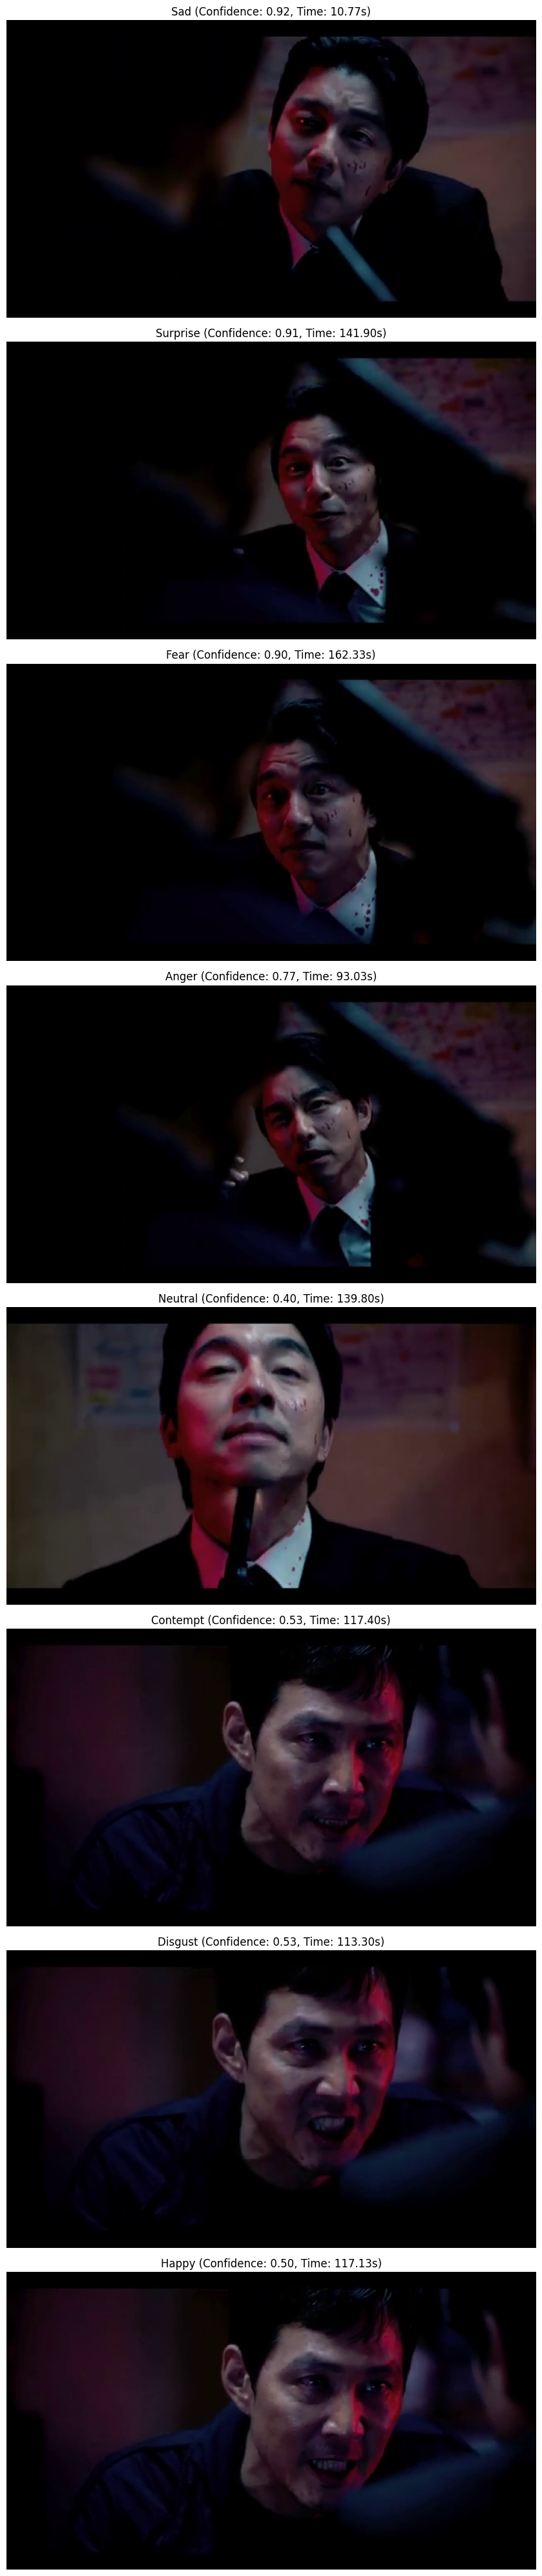

In [ ]:
# prompt: 결과파일을 이용해서 시각화도 진행해보자. 감정별로 가장 점수가 높았던 프레임을 프레임과 클래스를 같이 보여줘. 프레임은 fps를 바탕으로 계산해서 영상의 어느부분인지 시간으로 표시해줘.

import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

# 결과 CSV 파일 경로
csv_file = "pipelined_emotion_results_from_frames.csv"

# 프레임 이미지 폴더 경로
frames_folder = "/content/squid_game_example_frames/frames"

# 원본 비디오 경로 (FPS 정보를 위해 필요)
video_path = "/content/0003_youtube_trailer_01.mp4"

# 결과 DataFrame 로드
df = pd.read_csv(csv_file)

# FPS 정보 가져오기
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

# 감정별로 가장 높은 점수를 가진 프레임 찾기
top_emotions = {}
for emotion in df['emotion'].unique():
    top_frame = df[df['emotion'] == emotion].sort_values('confidence', ascending=False).iloc[0]
    top_emotions[emotion] = top_frame

# 결과 시각화
fig, axes = plt.subplots(len(top_emotions), 1, figsize=(10, 5 * len(top_emotions)))
if len(top_emotions) == 1: # axes가 1차원 배열일 경우 처리
    axes = [axes]

for i, (emotion, frame_data) in enumerate(top_emotions.items()):
    frame_index = int(frame_data['frame_index'])
    frame_time = frame_index / fps
    frame_filename = frame_data['filename']
    confidence = frame_data['confidence']

    frame_path = os.path.join(frames_folder, frame_filename)
    img = cv2.imread(frame_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR to RGB for matplotlib

    axes[i].imshow(img)
    axes[i].set_title(f"{emotion} (Confidence: {confidence:.2f}, Time: {frame_time:.2f}s)")
    axes[i].axis('off')

plt.tight_layout()
plt.show()